In [1]:
import pandas as pd
import numpy as np
import os
import string
import datetime
os.getcwd()
import glob



In [2]:
def convert_mm(value):
    #length in mm transformed to float
    try:
        new_value = value.replace(' mm','')
        return float(new_value)    
    except AttributeError:
        return np.NaN

In [3]:
def convert_exposure(value):
    #length in mm transformed to float
    try:
        list_string=value.split('/')
        if (len(list_string)==1):
            return float(value)
        else:
            return float(list_string[0])/float(list_string[1])
    except AttributeError:
        #print ('WTF',value)
        return np.NaN
    #return float(0)
        

In [4]:
def remove_full_path(value):
    #all pictures originate from a Pictures folder, remove the full path
    #including Pictures
    try:
        list_string=value.split('/Pictures')
        return list_string[1]
    except AttributeError:
        return np.NaN

In [5]:
def funcDayPeriod(filename):
    search_night=["bei Nacht",'Sternenhimmel',"Mondschein","Mond","Ice and Snow/"]
    search_night_special=["Lumiere","euerwerk","Firework","Freudenfeuer"]
    search_twilight=["bei anbrechender Nacht","Abenddaemmerung","Morgendaemmerung","Sonnenaufgang"]
    if any (x in filename for x in search_night):
        return -1
    elif any(x in filename for x in search_night_special):
         return 0
    elif any(x in filename for x in search_twilight):
        return 3
    elif "bei Sonnenuntergang" in filename:
        return 2
    else:
        return 1

In [6]:
def funcComposite(filename):
    if "Panorama." in filename:
        return 1
    else:
        return 0

In [7]:
def funcMovie(filename):
    search_file_names=[".JPG",".jpg",".JPEG",".jpeg"]
    if any(x in filename for x in search_file_names):
        return 0
    else:
        return 1

In [17]:
def funcTimeZoneCorrectionNYCBias(value,filename,modelname,data_min,data_max):
    try:
        if value=='0000:00:00 00:00:00' or value=='missing':
            return np.NaN
        else:
            #date example: Dec 09 Sat ,2006, 17:12:27
            #abrMonth day(number zero-padded) day(abbr name),year, hour(24):minute:second
            #date is ordered by 
            date_orig = datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S") 
            date = datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S") 
            datemin = datetime.strptime(data_min,"%b %d %a ,%Y, %H:%M:%S") 
            datemax = datetime.strptime(data_max,"%b %d %a ,%Y, %H:%M:%S") 
            if modelname=="SP500UZ":
                if(date>datemin and date<datemax):
                #never changed timezone after getting back from NYC, all messed up
                    date=date+datetime.timedelta(hours=6)
                    #print('date before',date_orig,'date after',date)
            return date.strftime("%b %d %a ,%Y, %H:%M:%S")
    except AttributeError:
        return np.NaN

In [18]:
def funcTimeZoneCorrection(value,filename,modelname):
    try:
        if value=='0000:00:00 00:00:00' or value=='missing':
            return np.NaN
        else:
            #date example: Dec 09 Sat ,2006, 17:12:27
            #abrMonth day(number zero-padded) day(abbr name),year, hour(24):minute:second
            date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S") 
            search_names_NYC_time_zone=["- Philadelphia,","New York City,","Newark,","Washington Airport"]
            search_names_London_time_zone_CANON600D=["Dublin & Nordirland/P","120830-120909 - Portugal/","Suedengland/","141212-141214 - London/","Greater London"]
            search_names_Istanbul_time_zone_CANON600D=["41023-141027 - Istanbul/","150828-150912 Sankt Petersburg/"]
            search_names_pacific_time_zone_CANON600D=["150613 - Los Angeles/","USA/P818"," - Grand Canyon Village, "," - Boulder City, "," - Las Vegas, "]
            search_names_China_time_zone_CANON80D=["180101 China/","/171230 Shanghai"," - China, "]
            search_names_EastEurope_time_zone_CANON80D=["170603 Athen/","171006 Tallinn ","/170414 Kiev"," - Tuerkei, "," - Irak, "," - Kuwait"," - Qatar, "]
            search_names_London_time_zone_CANON80D=[" - Saudi-Arabien,","/190413-190417 Suedostengland/"," - United Kingdom - ","/171110 Marrakesch/","170915 London/P","/180602 UK/"]
            search_names_Iceland_time_zone_CANON80D=[" - Island, ","/180328 Island/"]
            search_names_Gulf_time_zone_CANON80D=[" - Island, "," - Dubai, "]
            search_names_Pakistan_time_zone_CANON80D=[" - Pakistan, "]
            search_names_Korea_time_zone_CANON80D=[" - Paju, "," - Suwon, "," - Seoul, "," - Busan,"," - Incheon, "," - Gyeongju, "," - Gwanju, "]
            if modelname=="SP500UZ":
                #no change of default time, thus London time is an hour too late
                if "London/P" in filename:
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=1)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif any(x in filename for x in search_names_NYC_time_zone):
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=6)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif " Chicago - Edit2012/P" in filename:
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=7)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")      
                else:
                    return value;
            if modelname=="Canon EOS 600D":
                #all of EOS600D done including 2015
                if any(x in filename for x in search_names_London_time_zone_CANON600D):
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=1)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif any(x in filename for x in search_names_Istanbul_time_zone_CANON600D):
                    date=date+datetime.timedelta(hours=1)
                    date = datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif any(x in filename for x in search_names_pacific_time_zone_CANON600D):
                    date = datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=9)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif "- Chicago, " in filename:
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=7)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif " - Washington D.C., " in filename:
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=6)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif "/160813 - USA/" in filename:
                    #remaining 2016 US trip times
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=8)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif "161205 - Japan/" in filename:
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date+datetime.timedelta(hours=7)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                else:
                    #change to default summer time
                    date = datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
            if modelname=="Canon PowerShot S110":  
                 #all running on summer time
                if any(x in filename for x in search_names_London_time_zone_CANON600D):
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=2)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif "41023-141027 - Istanbul/" in filename:
                    #for Istanbul timezone was not aligned with CANON EOS600D
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=1)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif "150613 - Los Angeles/" in filename:
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=10)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif "/2016/" in filename:
                    if "161205 - Japan/" in filename:
                        date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                        date=date+datetime.timedelta(hours=6)
                        return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                    else:
                        #change to default summer time
                        date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                        date=date-datetime.timedelta(hours=1)
                        return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                else:
                    #change to default summer time
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=1)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
            if modelname=="Canon EOS 80D":
                if any(x in filename for x in search_names_China_time_zone_CANON80D):
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date+datetime.timedelta(hours=6)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif any(x in filename for x in search_names_EastEurope_time_zone_CANON80D):
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date+datetime.timedelta(hours=1)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif any(x in filename for x in search_names_London_time_zone_CANON80D):
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=1)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif " - Groenland" in filename:
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=4)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S") 
                elif any (x in filename for x in search_names_Iceland_time_zone_CANON80D):
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=2)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S") 
                elif "/170609 USA/" in filename:
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date-datetime.timedelta(hours=8)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")  
                elif any(x in filename for x in search_names_Gulf_time_zone_CANON80D):
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date+datetime.timedelta(hours=2)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif any(x in filename for x in search_names_Pakistan_time_zone_CANON80D):
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date+datetime.timedelta(hours=3)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                elif any(x in filename for x in search_names_Korea_time_zone_CANON80D):
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    date=date+datetime.timedelta(hours=7)
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
                else:
                    #always on summer time
                    date = datetime.datetime.strptime(value,"%b %d %a ,%Y, %H:%M:%S")  
                    return date.strftime("%b %d %a ,%Y, %H:%M:%S")
    except AttributeError:
        return np.NaN

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


dataframe_list=[]

data_max=datetime.datetime.now()
datamax=data_max.strftime("%b %d %a ,%Y, %H:%M:%S")
data_min=datetime.datetime.now()
datamin=data_min.strftime("%b %d %a ,%Y, %H:%M:%S")

#print(datamin,datamax)

#push-back day related periods, 1 for day,2 for sunset,3 for dusk and daw,sunrise, 0 for night
for input in range(2006,2020):
    #print("get to year",input)
    df=pd.read_csv("outputEXIFcsvs/PhotoEXIFDataDayType_%s.csv"%(str(input)))
    #push back year index as additional list 
    #print(df.columns,df.head)
    #print(df.dtypes)
    df['SourceFile']=df['SourceFile'].apply(remove_full_path)    
    df['FocalLength']=df['FocalLength'].apply(convert_mm) 
    df['ExposureTime']=df['ExposureTime'].apply(convert_exposure)
    df['DateTimeOriginal']=df['DateTimeOriginal'].fillna('missing')
    df['year']=int(input)
    df['dayperiod']=df.apply(lambda x: funcDayPeriod(x['SourceFile']), axis=1)
    df['CompositePhoto']=df.apply(lambda x: funcComposite(x['SourceFile']), axis=1)
    df['Movie']=df.apply(lambda x: funcMovie(x['SourceFile']), axis=1)
    df.rename(columns={'DateTimeOriginal':'Date','FocalLength':'FocalLength in mm'},inplace=True) 
    df['Date']=df.apply(lambda x: funcTimeZoneCorrection(x['Date'],x['SourceFile'],x['Model']), axis=1)
    df['Date']=df['Date'].fillna('missing')
    total_rows=df['SourceFile'].count()
    if(input==2009 or input ==2010):
        if input==2009:
            test=df.loc[df['SourceFile'].str.contains("P7080022 - New York City")]
            #print("correction should start somewhere here",test,"index is",test.index.values.astype(int)[0])
            datamin=df.at[test.index.values.astype(int)[0],"Date"]   
            df['Date']=df.apply(lambda y: funcTimeZoneCorrectionNYCBias(y['Date'],y['SourceFile'],y['Model'],datamin,datamax), axis=1)
        elif input==2010:    
            test=df.loc[df['SourceFile'].str.contains("P8270068 - Le Locle, unterirdische Muehlen")]
            #print("correction should end somewhere here",test,"index is",test.index.values.astype(int)[0])
            datamax=df.at[test.index.values.astype(int)[0],"Date"]   
            df['Date']=df.apply(lambda y: funcTimeZoneCorrectionNYCBias(y['Date'],y['SourceFile'],y['Model'],datamin,datamax), axis=1)
    df = df.replace(r'^\s+$', np.nan, regex=True)
    dataframe_list.append(df)
    #df['Date']=df[df.Date!='missing']
    #date_stripped=df[~df['Date'].str.contains("missing")]
    #print("rows per year", input,total_rows)
    #print(df.dtypes)
    #df['Date'] = pd.to_datetime(date_stripped['Date'], format="%b %d %a ,%Y, %H:%M:%S")
   # fig = plt.figure(figsize = (10,6))
    #ax = fig.add_subplot(111)

    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %a ,%Y, %H:%M:%S'))
    #df["Date"].plot(ax=ax, kind='bar')
    #plt.plot(df['Date'])
    #plt.show()
    #hist = df.hist()
 
combine_all_data=pd.DataFrame(dataframe_list[0]) 
#print(combine_all_data.head)
#print("now for the rest")
dataframe_list.pop(0)
for data in dataframe_list:
    #print(data.head)
    combine_all_data=pd.concat([combine_all_data,data],ignore_index=True,sort=False)
    #print(combine_all_data.head)
    
combine_all_data.to_csv(r'EXIFDataCombinedCameras_2006_to_2019_DateLocalTime.csv')
print(combine_all_data.head)

<bound method NDFrame.head of                                               SourceFile  \
0      /2006/060710 - London/P7100001 - Basel, Easyje...   
1      /2006/060710 - London/P7100002 - London, Leice...   
2      /2006/060710 - London/P7100003 - London, House...   
3      /2006/060710 - London/P7100004 - London, Westm...   
4      /2006/060710 - London/P7100005 - London, St. M...   
...                                                  ...   
91783    /2019/190708 CMS/P7080006 - Cessy, P5 - CMS.JPG   
91784  /2019/190708 CMS/P7080001 - Cessy, P5 - LEP Ka...   
91785    /2019/190708 CMS/P7080003 - Cessy, P5 - CMS.JPG   
91786    /2019/190708 CMS/P7080005 - Cessy, P5 - CMS.JPG   
91787    /2019/190708 CMS/P7080007 - Cessy, P5 - CMS.JPG   

                             Date  FocalLength in mm  ExposureTime  \
0      Jul 10 Mon ,2006, 11:36:06                6.3      0.001250   
1      Jul 10 Mon ,2006, 15:52:49                6.3      0.003125   
2      Jul 10 Mon ,2006, 16:17:26      

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89582 entries, 0 to 91545
Data columns (total 21 columns):
Unnamed: 0             89582 non-null int64
SourceFile             89582 non-null object
Date                   89525 non-null datetime64[ns]
FocalLength in mm      89582 non-null float64
ExposureTime           89582 non-null float64
Model                  89582 non-null object
ISO                    89511 non-null float64
Aperture               89582 non-null object
LightValue             89511 non-null float64
year                   89582 non-null int64
dayperiod              89582 non-null int64
CompositePhoto         89582 non-null int64
Movie                  89582 non-null int64
MeasuredEV             62244 non-null float64
MeasuredRGGB           59521 non-null object
WB_RGGBLevelsAsShot    59521 non-null object
ColorTemperature       59779 non-null float64
ColorTempDaylight      59521 non-null float64
TimeZone               33576 non-null object
DaylightSavings        335

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


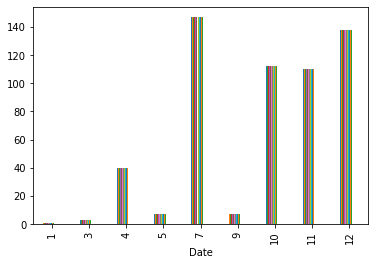

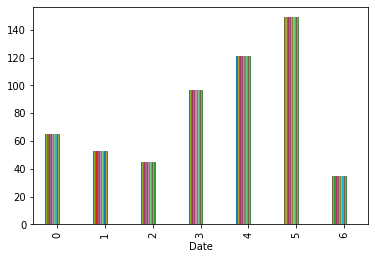

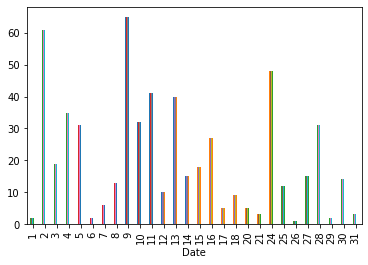

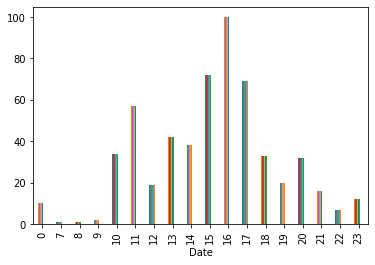

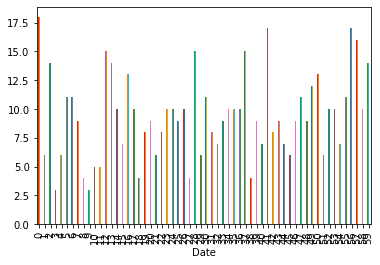

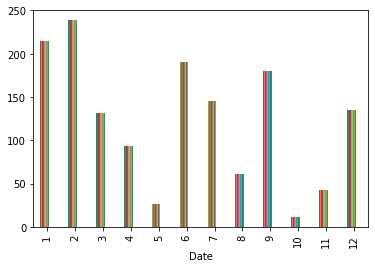

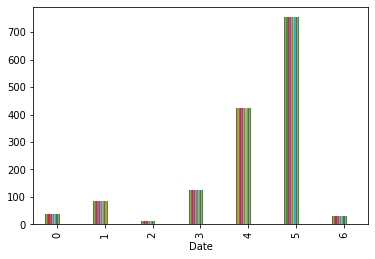

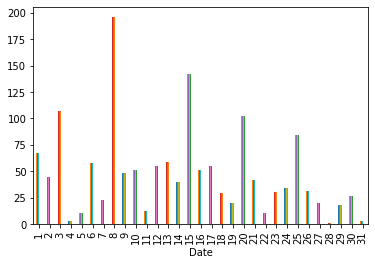

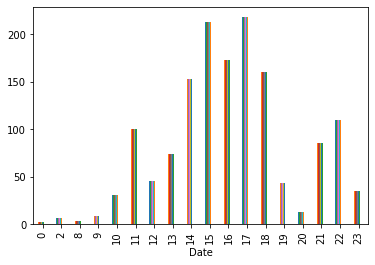

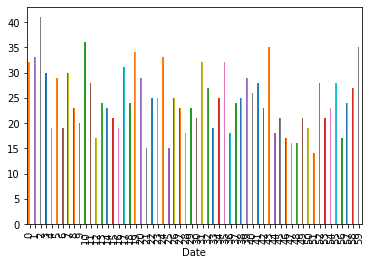

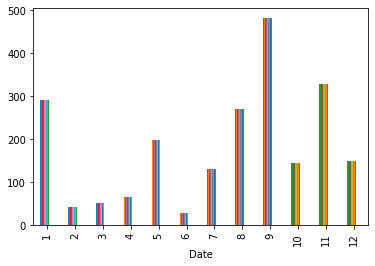

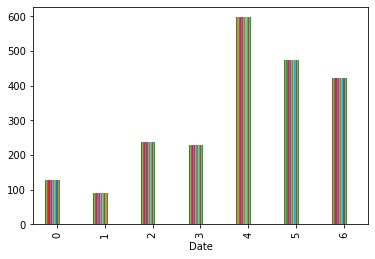

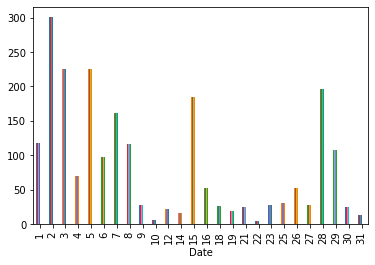

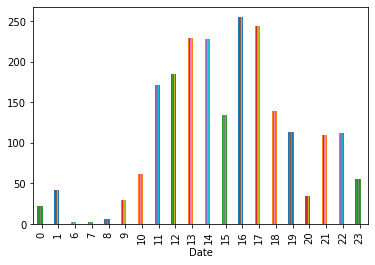

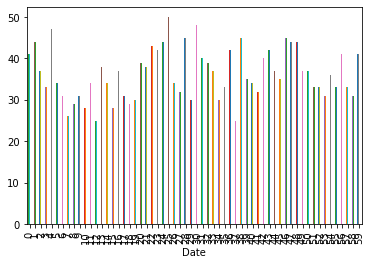

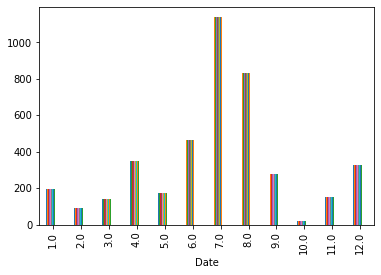

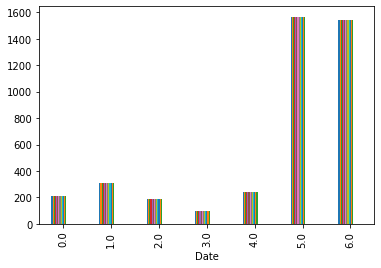

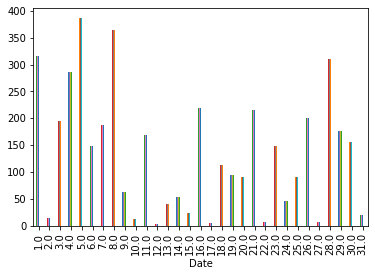

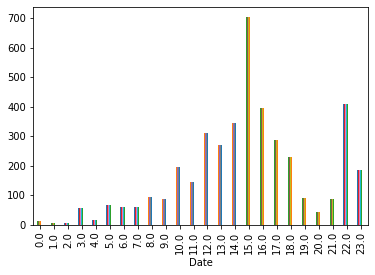

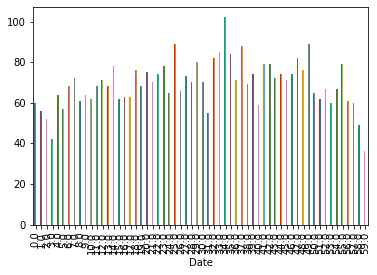

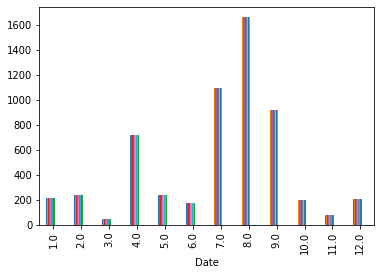

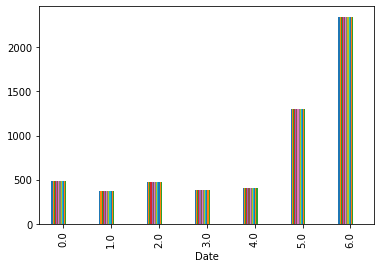

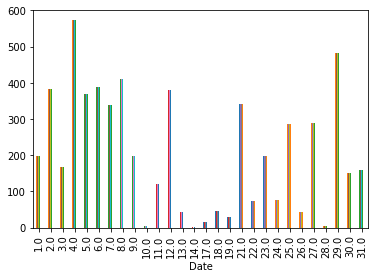

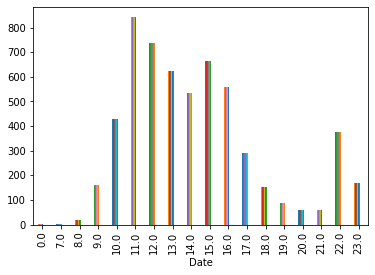

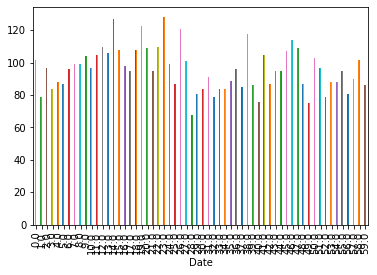

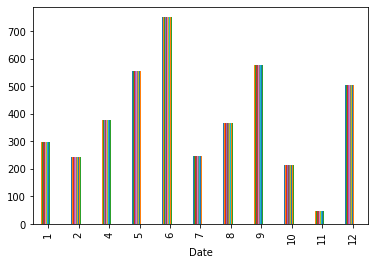

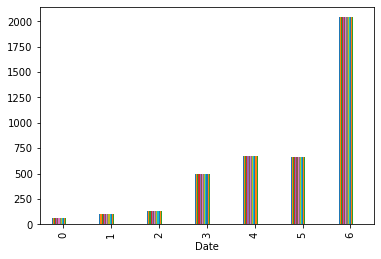

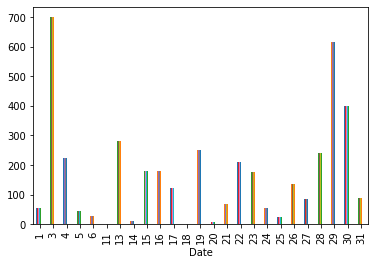

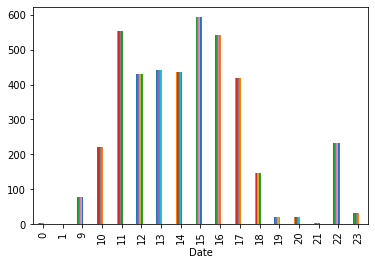

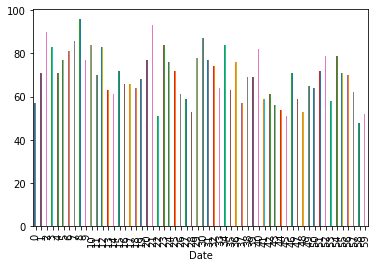

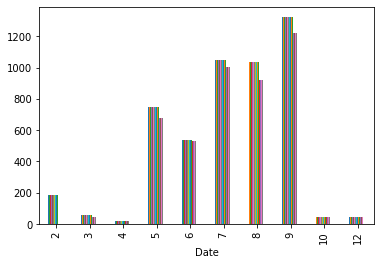

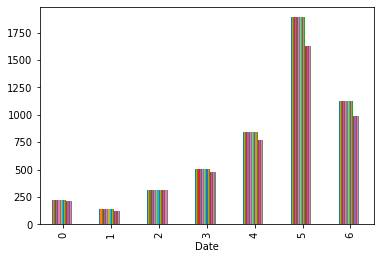

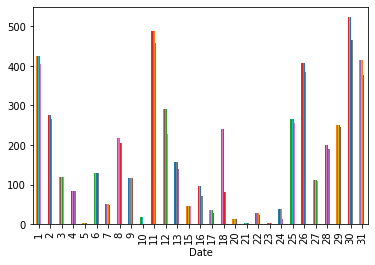

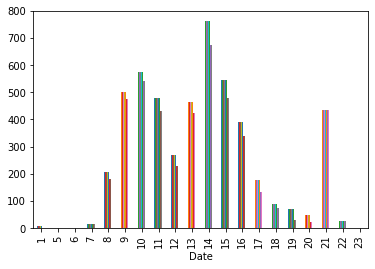

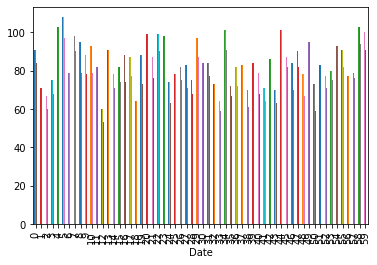

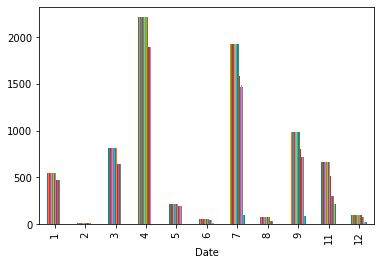

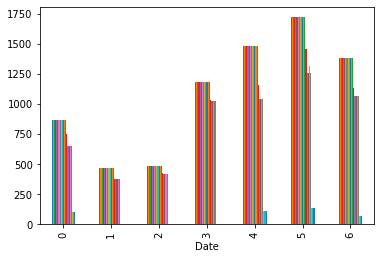

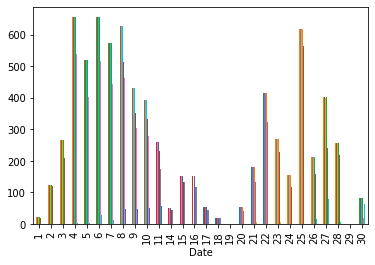

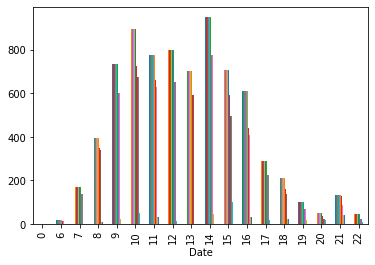

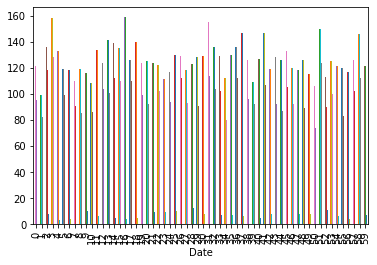

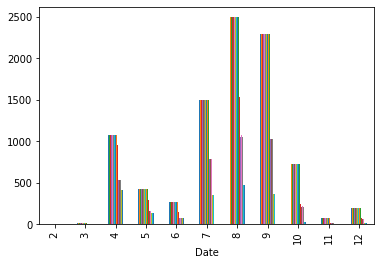

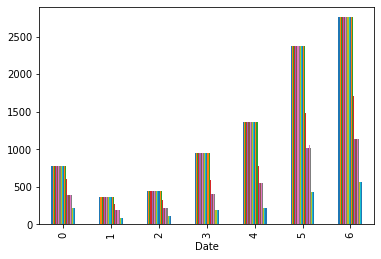

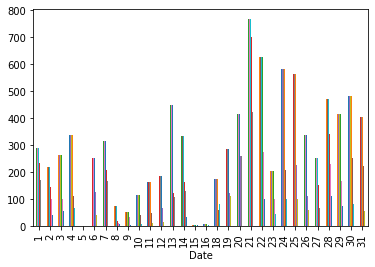

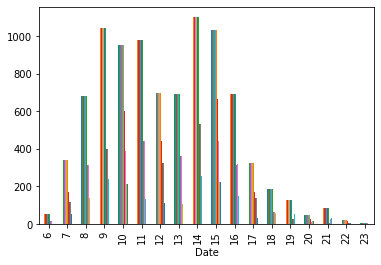

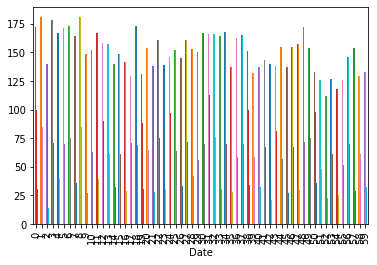

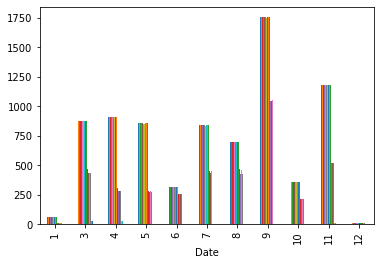

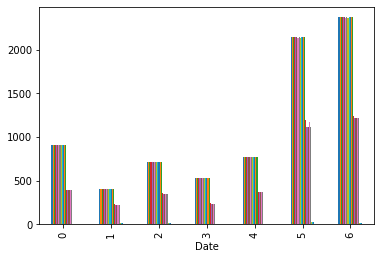

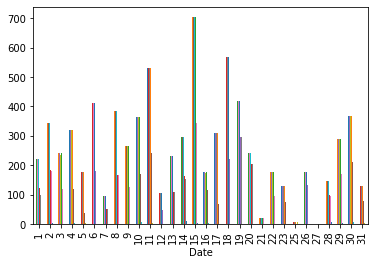

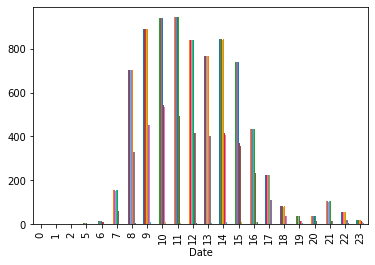

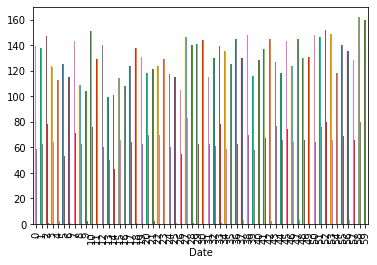

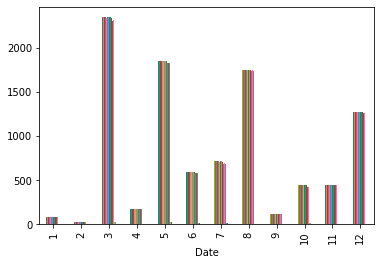

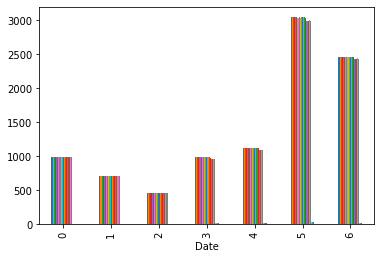

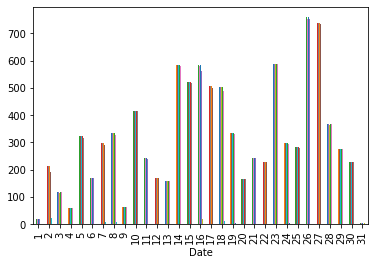

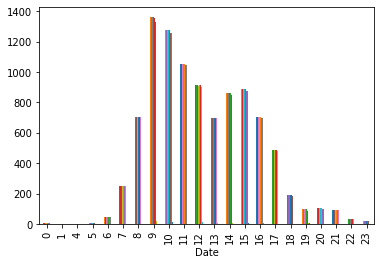

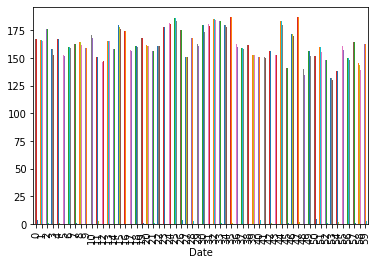

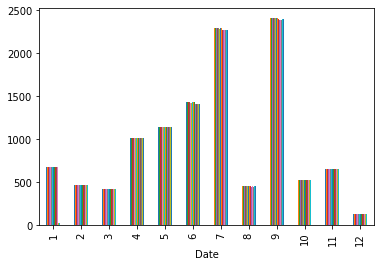

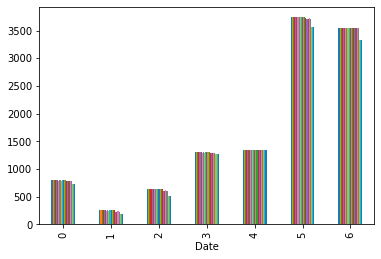

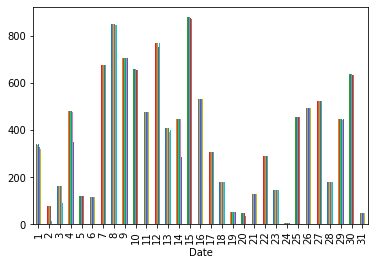

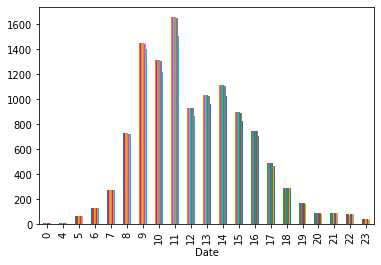

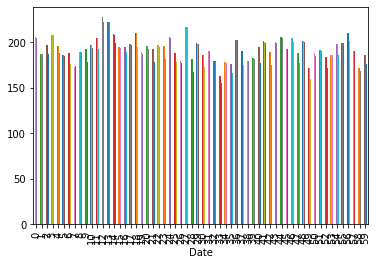

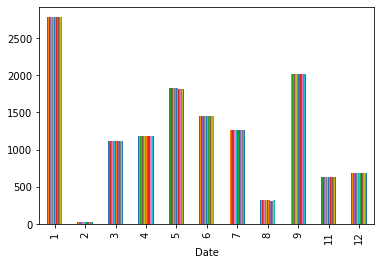

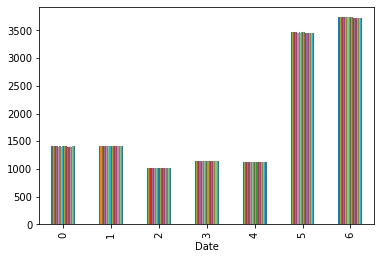

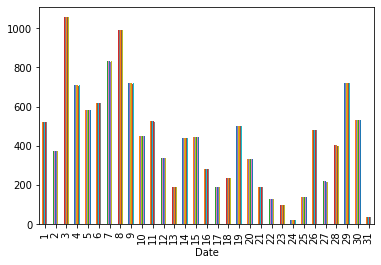

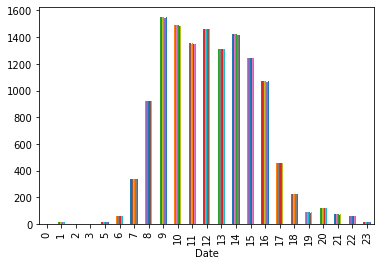

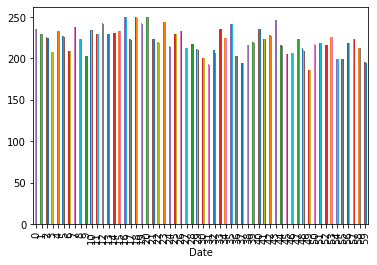

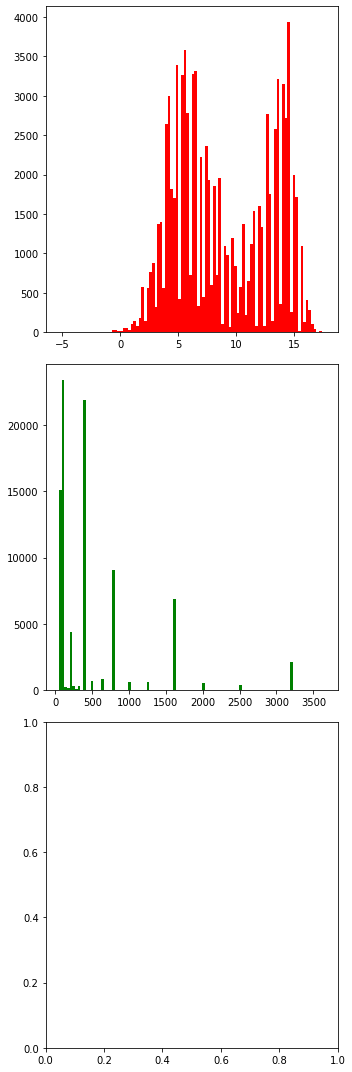

In [54]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from math import log
#import seaborn as sns


dataframe_list=[]

data_max=datetime.datetime.now()
datamax=data_max.strftime("%b %d %a ,%Y, %H:%M:%S")
data_min=datetime.datetime.now()
datamin=data_min.strftime("%b %d %a ,%Y, %H:%M:%S")


df=pd.read_csv("EXIFDataCombinedCameras_2006_to_2019_DateLocalTimeFinal.csv")
#df['Aperture']=df['Aperture'].
df_new=df.dropna(axis=0, how='all', subset=['ISO','ExposureTime','LightValue'])
df_new=df_new[df_new['Date']!='missing']
df_new['Date']=pd.to_datetime(df_new['Date'],format='%b %d %a ,%Y, %H:%M:%S')
#fails
#df_new['Date']=pd.Timestamp(df_new['Date'],format='%b %d %a ,%Y, %H:%M:%S')
d_low=datetime.date(2011, 12, 31)
print(df_new.info())
print(d_low)
for year in range(2006,2019): 
    df_new_1=df_new[(df_new['year']==year)]
    df_new_1.groupby(df_new_1["Date"].dt.month).count().plot(kind="bar",legend=None)
    df_new_1.groupby(df_new_1["Date"].dt.weekday).count().plot(kind="bar",legend=None)
    df_new_1.groupby(df_new_1["Date"].dt.day).count().plot(kind="bar",legend=None)
    df_new_1.groupby(df_new_1["Date"].dt.hour).count().plot(kind="bar",legend=None)
    df_new_1.groupby(df_new_1["Date"].dt.minute).count().plot(kind="bar",legend=None)
#df_new.groupby(df_new["Date"].dt).count().plot(kind="bar",legend=None)
#date_mask = (df_new['Date']>pd.Timestamp(2012,1,1,0)).all()
#df_new_2=df_new[(df_new['Date']>'2018-01-01 0:00:00') & (df_new['Date']<'2019-01-01 0:00:00')]
#df_new_2.groupby(df_new_2["Date"].dt.month).count().plot(kind="bar",legend=None)
#df_new_2.groupby(df_new_2["Date"].dt.weekday).count().plot(kind="bar",legend=None)
#df_new_2.groupby(df_new_2["Date"].dt.day).count().plot(kind="bar",legend=None)
#df_new_2.groupby(df_new_2["Date"].dt.hour).count().plot(kind="bar",legend=None)
#df_new_2.groupby(df_new_2["Date"].dt.minute).count().plot(kind="bar",legend=None)
#df_new.groupby(df_new["Date"].dt).count().plot(kind="bar",legend=None)

print(df_new)
df_new.to_csv(r'test.csv')
#at this point, iso, exposure,lightvalue and dates are all properly filled
print(df.dtypes)
print(df_new.info())
#df_new.plot('ISO')
#kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)
fig, axs = plt.subplots(3, 1, figsize=(5, 15), sharex=False, sharey=False,
                        tight_layout=True)
axs[0].hist(df_new['LightValue'], color=['red'],bins=100)
axs[1].hist(df_new['ISO'], color=['green'],bins=100,range=(50,3650))
#axs[2].hist(np.log(df_new['ExposureTime']), color=['orange'],bins=250,range=(-20,20))
plt.show()